In [1]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [2]:
import csv
import random

def reservoir_sampling(iterable, k, header=True):
    reservoir = []
    for i, item in enumerate(iterable):
        if i < k:
            reservoir.append(item)
        else:
            j = random.randint(0, i)
            if j < k:
                reservoir[j] = item
    return reservoir

# Open the input CSV file
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv") as f:
    # Check if header line exists
    header = True
    first_line = f.readline()
    if not first_line.startswith('step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud'):
        header = False
        f.seek(0)  # Rewind file pointer to beginning

    # Sample from remaining lines
    sampled_lines = reservoir_sampling(f, k=2500000, header=header)

# Open the output CSV file and write the subsample to it
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\transfer_learning.csv", mode='w', newline='') as f:
    writer = csv.writer(f)
    if header:
        writer.writerow(first_line.strip().split(','))
    for line in sampled_lines:
        writer.writerow(line.strip().split(','))

In [3]:
df_sample_big=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\transfer_learning.csv")

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['type'])
label
df_sample_big.drop("type", axis=1, inplace=True)
df_sample_big["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['nameDest'])
label
df_sample_big.drop("nameDest", axis=1, inplace=True)
df_sample_big["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['nameOrig'])
label
df_sample_big.drop("nameOrig", axis=1, inplace=True)
df_sample_big["nameOrig"] = label

In [5]:
from sklearn.model_selection import train_test_split

X = df_sample_big.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample_big['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998711
1    0.001289
Name: isFraud, dtype: float64
0    0.998711
1    0.001289
Name: isFraud, dtype: float64
0    0.998712
1    0.001288
Name: isFraud, dtype: float64


In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [7]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [8]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [9]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [10]:
# import the necessary libraries
import pandas as pd
import numpy as np
# convert X_test to a pandas dataframe
X_test = pd.DataFrame(X_test, columns=X_train.columns)
# define a function to replace outliers with MAD for a single column
def replace_outliers_with_mad(column):
    median = np.median(column)
    mad = np.median(np.abs(column - median))
    threshold = 2.5 * mad
    column[np.abs(column - median) > threshold] = median
    return column

# apply the function to all columns of X_train_resampled_final
for i in range(X_train_resampled_final.shape[1]):
    X_train_resampled_final.iloc[:, i] = replace_outliers_with_mad(X_train_resampled_final.iloc[:, i])

# apply the function to all columns of X_test
for i in range(X_test.shape[1]):
    X_test.iloc[:, i] = replace_outliers_with_mad(X_test.iloc[:, i])

# convert the numpy arrays back to pandas dataframes
X_train_resampled_final = pd.DataFrame(X_train_resampled_final, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

# print the modified dataframes
print(X_train_resampled_final)
print(X_test)

C:\Users\23059\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


         step         amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         182    6902.570000            0.0             0.0        0.000000   
1          18  294611.040000        52672.0             0.0    51462.377834   
2         227   65510.640000            0.0             0.0        0.000000   
3         161   21291.730000            0.0             0.0        0.000000   
4         276   81175.720000        51871.0             0.0    51462.377834   
...       ...            ...            ...             ...             ...   
1472494    78  139807.757001        51871.0             0.0        0.000000   
1472495   397  384482.845922        51871.0             0.0        0.000000   
1472496   276  292578.241961        51871.0             0.0    51462.377834   
1472497   360  332096.985800        51871.0             0.0        0.000000   
1472498    66  139807.757001        51871.0             0.0        0.000000   

         newbalanceDest  isFlaggedFraud  type  name

C:\Users\23059\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [11]:
# import module
from sklearn.preprocessing import StandardScaler

# compute required values
scaler = StandardScaler()
model = scaler.fit(X_train_resampled_final)
X_train_resampled_final = model.transform(X_train_resampled_final)

In [12]:
# compute required values
scaler = StandardScaler()
model = scaler.fit(X_test)
X_test = model.transform(X_test)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5745/5752 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9184WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001E07B547C18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5752/5752 [==============================] - 30s 5ms/step - loss: 0.1804 - accuracy: 0.9184 - val_loss: 0.1493 - val_accuracy: 0.9321
Epoch 2/10
5752/5752 [==============================] - 28s 5ms/step - loss: 0.1390 - accuracy: 0.9383 - val_loss: 0.1304 - val_accuracy: 0.9421
Epoch 3/10
5752/5752 [==============================] - 28s 5ms/step - loss: 0.1215 - accuracy: 0.9469 - val_loss: 0.1153 - val_accuracy: 0.9506
Epoch 4/10
5752/5752 [==============================] - 30s 5ms/step - loss: 0.1081 - accuracy: 0.9543 - val_loss: 0.1035 - val_accuracy: 0.9571
Epoch 5/10
5752/5752 [==============================] - 31s 5ms/step - loss: 0.0974 - accuracy: 0.9604 - val_loss: 0.093

Fold 1 elapsed time: 294.68 seconds
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5737/5752 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9179WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001E07B2F1708> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5752/5752 [==============================] - 32s 5ms/step - loss: 0.1808 - accuracy: 0.9179 - val_loss: 0.1503 - val_accuracy: 0.9318
Epoch 2/10
5752/5752 [==============================] - 46s 8ms/step - loss: 0.1392 - accuracy: 0.9377 - val_loss: 0.1306 - val_accuracy: 0.9418
Epoch 3/10
5752/5752 [==============================] - 38s 7ms/step - loss: 0.1243 - accuracy: 0.9455 - val_loss: 0.1161 - val_accuracy: 0.9501
Epoch 4/10
5752/5752 [==============================] - 34s 6ms/step - loss: 0.1130 - accuracy: 0.9519 - val_loss: 0.1070 - val_accuracy: 0.9555
Epoch 5/10
5752/5752 [==============================] - 35s 6ms/step - loss: 0.1027 - accuracy: 0.9579 - val_loss: 0.098

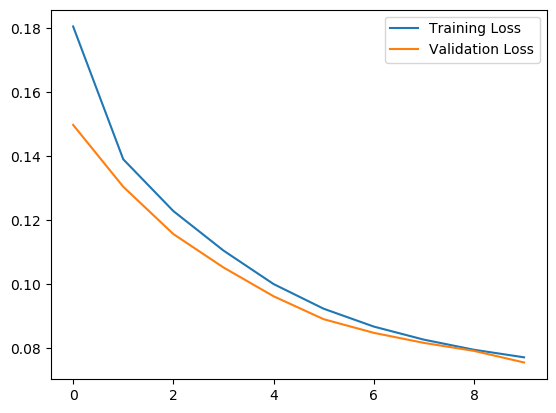

In [13]:
import numpy as np
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# define number of folds for cross-validation
num_folds = 2

# create KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True)

# create arrays to store training and validation loss for each epoch
train_losses = np.zeros((num_folds, 10))
val_losses = np.zeros((num_folds, 10))

import time

# loop over the folds
fold_no = 1
for train, val in kfold.split(X_train_resampled_final, y_train_resampled_final):
    
    # create model
    pre_trained_model = Sequential()
    # add convolutional layer
    pre_trained_model.add(Conv1D(filters=128, kernel_size=3, activation='tanh', input_shape=(10, 1)))
    # add pooling layer
    pre_trained_model.add(MaxPooling1D(pool_size=2))
    # flatten output to feed into fully connected layer
    pre_trained_model.add(Flatten())
    # add fully connected layer
    pre_trained_model.add(Dense(1, activation='sigmoid'))
    
    opt_new = Adam(lr=0.00033)
    # compile model
    pre_trained_model.compile(loss='binary_crossentropy', optimizer=opt_new, metrics=['accuracy'])
    
    # record start time
    start_time = time.time()
    
    # train model for each fold
    history = pre_trained_model.fit(X_train_resampled_final[train], y_train_resampled_final[train],
                                     epochs=10, batch_size=128, validation_data=(X_train_resampled_final[val], y_train_resampled_final[val]))
    
    # record end time and calculate elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'Fold {fold_no} elapsed time: {elapsed_time:.2f} seconds')
    
    # store training and validation loss for each epoch
    train_losses[fold_no-1] = history.history['loss']
    val_losses[fold_no-1] = history.history['val_loss']
    
    # increment fold number
    fold_no += 1
    
# calculate mean training and validation loss across all folds for each epoch
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

# plot training and validation loss curves for each epoch
plt.plot(mean_train_loss, label='Training Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.legend()
plt.show()